In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

# from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score, confusion_matrix

%run ../pyfiles/data_cleaning.py
%run ../pyfiles/grid_search.py
%run ../pyfiles/modeling.py
%run ../pyfiles/unmetDemand.py

In [5]:
# # Set global random seed
# np.random.seed(123)

### Import data and drop redundant data (rates)

In [6]:
# import data
df = pd.read_csv('../../data/deepsolar_tract.csv', encoding = "utf-8")

### Clean Data

In [7]:
df = drop_redundant_columns(df)

In [8]:
# Create our target column 'has_tiles', and drop additional redundant columns

df = create_has_tiles_target_column(df)

In [9]:
df.shape

(72537, 131)

In [6]:
# # # Figure out which variables are highly correlated, remove the most correlated ones one by one

# corr = pd.DataFrame((df.corr() > 0.8).sum())
# corr.sort_values(by = 0, ascending = False)[0:5]

In [7]:
# # # Add highly correlated variables to list 'to_drop'
# to_drop = ['poverty_family_count','education_population','population', 'household_count','housing_unit_occupied_count', 'electricity_price_overall']

In [8]:
# Drop highly colinear variables
# df = df.drop(to_drop, axis = 1)

In [9]:
# VIF score

### Checking for missing values

In [10]:
nulls = pd.DataFrame(df.isna().sum())
nulls.columns = ["missing"]
nulls[nulls['missing']>0].head()

,missing
average_household_income,886
gini_index,847
land_area,24
per_capita_income,643
population_density,316


In [10]:
# drop all missing values
df = df.dropna(axis = 0)

In [11]:
# Check class imbalance
df.has_tiles.value_counts()

1    41601
0    12498
Name: has_tiles, dtype: int64

In [12]:
df.shape

(54099, 131)

### Train test split

In [14]:
X = df.drop('has_tiles', axis = 1)
y = df['has_tiles']

In [15]:
df.shape

(54099, 131)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

## Sampling Techniques

In [17]:
# smote, undersampling, or oversampling
X_train, y_train = pick_sampling_method(X_train, y_train, method = 'oversampling')

In [18]:
y_train.value_counts()

1    33281
0    33281
Name: has_tiles, dtype: int64

### Scale Data 

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
X_train.shape

(66562, 130)

## Modeling

In [153]:
from sklearn.metrics import classification_report

### Vanilla Decision Tree 0.74     

In [85]:
## DUMMY
dummy = DecisionTreeClassifier()
dummy.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [86]:
y_pred = dummy.predict(X_test)

In [87]:
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))

Precision: 0.8467012423109396
Recall: 0.84375
Accuracy: 0.7623844731977819
F1 Score: 0.8452230449702004


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.82      0.37      2500
           1       0.79      0.21      0.33      8320

    accuracy                           0.35     10820
   macro avg       0.51      0.51      0.35     10820
weighted avg       0.66      0.35      0.34     10820



### Decision Tree with Hyperparameter Tuning

In [31]:
dt = find_hyperparameters(pipe_dt, params_dt, X_train, y_train)

In [32]:
dt.best_params_
best_dt = dt.best_estimator_
# Decision Tree: {'dt__max_depth': 2, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}

In [33]:
best_dt.fit(X_train, y_train)
best_dt.score(X_test, y_test)
# Decision Tree: 0.755637707948244

0.7474121996303142

In [34]:
y_pred_dt = best_dt.predict(X_test)
print("Precision: {}".format(precision_score(y_test, y_pred_dt)))
print("Recall: {}".format(recall_score(y_test, y_pred_dt)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_dt)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_dt)))

Precision: 0.9131785238869989
Recall: 0.7420673076923077
Accuracy: 0.7474121996303142
F1 Score: 0.8187785955838471


C:\Users\allis\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\allis\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


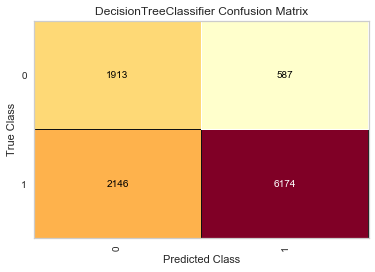

## Final Model

In [ ]:
# with oversampling

In [24]:
rf = RandomForestClassifier(max_features = 'sqrt', max_depth = 5, min_samples_leaf = 5, n_estimators = 30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [25]:
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))

Precision: 0.9180549302116164
Recall: 0.7352163461538461
Accuracy: 0.7459334565619223
F1 Score: 0.8165253954481745
Balanced Accuracy: 0.758408173076923


C:\Users\allis\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\allis\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


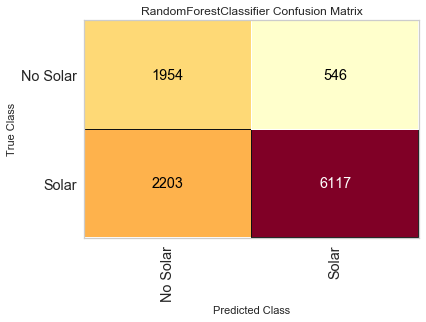

In [42]:
cm = ConfusionMatrix(rf, fontsize = 'x-large', classes = ['No Solar', 'Solar'])
cm.score(X_test, y_test)
cm.show()

### Vanilla Random Forests

In [87]:
rf = RandomForestClassifier()

In [88]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [95]:
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {}".format(f1_score(y_test, y_pred)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred)))

Precision: 0.8665596698383584
Recall: 0.9085336538461538
Accuracy: 0.8220887245841035
F1 Score: 0.8870504019245439
Balanced Accuracy: 0.7214668269230768


C:\Users\allis\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\allis\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


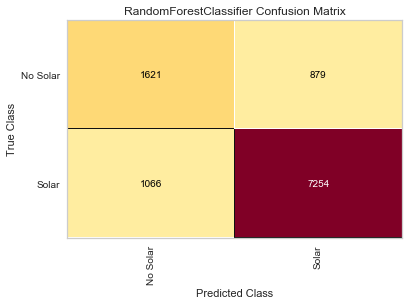

In [113]:
cm_rf = ConfusionMatrix(rf, classes = ['No Solar', 'Solar'], label_encoder={0: 'No Solar', 1: 'Solar'})
cm_rf.score(X_test, y_test)
cm_rf.poof()

In [89]:
# vanilla with smote
# Precision: 0.8955014655282274
# Recall: 0.8445913461538461
# Accuracy: 0.804713493530499
# F1 Score: 0.8693016638832188
# Balanced Accuracy: 0.758295673076923

In [111]:
# vanilla with oversampling
# Precision: 0.8665596698383584
# Recall: 0.9085336538461538
# Accuracy: 0.8220887245841035
# F1 Score: 0.8870504019245439
# Balanced Accuracy: 0.7214668269230768

### Random Forests with Hyperparameter Tuning

In [56]:
### Random Forests
rf = find_hyperparameters(pipe_rf, params_rf, X_train, y_train)

In [57]:
print(rf.best_params_)
best_rf = rf.best_estimator_

#first hyperparamter tuning: {'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 20, 'rf__n_estimators': 30}
# Second tuning: {'rf__min_samples_leaf': 5, 'rf__n_estimators': 50}

{'rf__min_samples_leaf': 5, 'rf__n_estimators': 50}


In [58]:
best_rf.fit(X_train, y_train)
best_rf.score(X_test, y_test)
# Random Forests: 0.793807763401109

0.8207948243992607

In [59]:
y_pred_rf = best_rf.predict(X_test)
print("Precision: {}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {}".format(recall_score(y_test, y_pred_rf)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_rf)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_rf)))
print("Balanced Accuracy: {}".format(balanced_accuracy_score(y_test, y_pred_rf)))

Precision: 0.8924837003321442
Recall: 0.8719951923076923
Accuracy: 0.8207948243992607
F1 Score: 0.8821204936470303
Balanced Accuracy: 0.7611975961538462


### Vanilla SVC

In [22]:
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
y_pred_svc = svc.predict(X_test)

In [24]:
print("Precision: {}".format(precision_score(y_test, y_pred_svc)))
print("Recall: {}".format(recall_score(y_test, y_pred_svc)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_svc)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_svc)))

Precision: 0.9094472225976483
Recall: 0.8087740384615385
Accuracy: 0.7910351201478744
F1 Score: 0.8561613334181563


### SVC with Hyperparameter Tuning

In [ ]:
svc = find_hyperparameters(pipe_svc, params_svc, X_train, y_train)

In [ ]:
print(svc.best_params_)
best_svc = svc.best_estimator_

In [ ]:
best_svc.fit(X_train, y_train)
best_svc.score(X_test, y_test)

In [ ]:
y_pred_svc = best_svc.predict(X_test)
print("Precision: {}".format(precision_score(y_test, y_pred_svc)))
print("Recall: {}".format(recall_score(y_test, y_pred_svc)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_svc)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_svc)))

### Vanilla KNN

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [24]:
y_pred_knn = knn.predict(X_test)
print("Precision: {}".format(precision_score(y_test, y_pred_knn)))
print("Recall: {}".format(recall_score(y_test, y_pred_knn)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_knn)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_knn)))

Precision: 0.9354388413889374
Recall: 0.6443509615384615
Accuracy: 0.6923290203327171
F1 Score: 0.7630773610419187


### KNN with Hyperparameter Tuning

In [ ]:
knn = find_hyperparameters(pipe_knn, params_knn, X_train, y_train)

In [23]:
print(knn.best_params_)
best_knn = knn.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
best_knn.fit(X_train, y_train)
best_knn.score(X_test, y_test)

In [ ]:
y_pred_knn = best_knn.predict(X_test)
print("Precision: {}".format(precision_score(y_test, y_pred_knn)))
print("Recall: {}".format(recall_score(y_test, y_pred_knn)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred_knn)))
print("F1 Score: {}".format(f1_score(y_test, y_pred_knn)))

### Preliminary Conclusions: Model Performance Comparisons

Based on comparisons of both accuracy and balanced accuracy scores, our Random Forest Classifier model performed the best with oversampling methods and hyperparameter tuning. 


In [24]:
falsepositives = isFalsePositive(df, X_test, y_test, rf)

In [25]:
inversefalsepositives = scaler.inverse_transform(falsepositives)
inversefalsepositives = pd.DataFrame(inversefalsepositives)
inversefalsepositives = inversefalsepositives.set_axis(falsepositives.columns, axis=1, inplace=False)

In [28]:
len(inversefalsepositives)

873

In [254]:
ozdf = pd.read_csv("../data/ListOfOppurtunityZonesWithoutAKorHI.csv", encoding = "utf-8")
ozdf = ozdf.rename(columns={"Census Tract Number": "Census_Tract_Number", "Tract Type": "Tract_Type", "ACS Data Source": "ACS_Data_Source"})
# results = pd.merge(inversefalsepositives, ozdf, left_on = inversefalsepositives.fips, right_on = ozdf.Census_Tract_Number)

In [29]:
results.to_csv('../data/results.csv')

### Running Model on Entire Dataset

In [167]:
ozdf = ozdf['Census_Tract_Number']

In [169]:
merged = df.merge(ozdf, how = 'left', left_on='fips',right_on='Census_Tract_Number')

In [170]:
merged = merged.dropna()

In [171]:
merged.drop('fips', axis = 1, inplace = True)

In [172]:
merged['has_tiles'].value_counts()

1    4505
0    1381
Name: has_tiles, dtype: int64

In [173]:
X_ozdf = merged.drop('has_tiles', axis = 1)
y_ozdf = merged['has_tiles']

In [174]:
y_pred_ozdf = rf.predict(X_ozdf)

In [175]:
y_pred_ozdf

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [176]:
y_pred_ozdf = pd.Series(y_pred_ozdf)

In [177]:
y_pred_ozdf.value_counts()

1    5886
dtype: int64

In [178]:
final = merged.merge(y_pred_ozdf.rename('y_pred'), how = 'left', on = merged.index)

In [179]:
final = final[final['y_pred'] == 1]

### Experimenting with Final Model

In [255]:
y_pred_all = rf.predict(X)
y_pred_all = pd.Series(y_pred_all)

In [256]:
predictions = df.merge(y_pred_all.rename('pred_'), how = 'left', on = df.index)

In [257]:
predictions = predictions.merge(ozdf, how = 'left', left_on='fips',right_on='Census_Tract_Number')

In [258]:
final_zones = predictions.dropna()

In [259]:
(final_zones.pred_).unique()

array([1], dtype=int64)

In [260]:
predictions['pred_'].value_counts()

1    54099
Name: pred_, dtype: int64

In [261]:
y_pred_train = rf.predict(X_train)

In [262]:
print("Precision: {}".format(precision_score(y_train, y_pred_train)))
print("Recall: {}".format(recall_score(y_train, y_pred_train)))
print("Accuracy: {}".format(accuracy_score(y_train, y_pred_train)))
print("F1 Score: {}".format(f1_score(y_train, y_pred_train)))

Precision: 0.7939935224261458
Recall: 0.7292449145157898
Accuracy: 0.7700189297196599
F1 Score: 0.760243077308608
